**Problem Statement**
* How do we find anomalies during hardware or hardware/software system validation in order to accelerate bug finding for faster time-to-market?
* Without answering this question, the hardware/system validation teams will not be able to identify anomalies or bugs quickly, and also will not be able to gain quick insights into what types of sequences or patterns cause these anomalies or bugs to occur within the hardware/system.  This will slow down the debugging required to ship the product out the door to the customer, negatively impacting the hardware business.

**Data Source**
* Data source is related to LogBERT-HDFS from Github:

    * https://github.com/HelenGuohx/logbert

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN

In [2]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline

In [7]:
import tensorflow as tf
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

**Tokenization and Initial Pre-processing:**

Tokenization and some pre-processing of original logfile, HDFS.log, was done using scripts from the GitHub website below:
https://github.com/HelenGuohx/logbert

These scripts were created by the author of the above website.

After these scripts were run, hdfs_sequence_labels.csv was created, where the tokens are represented as a list of token IDs within the column EventSequence.

In [9]:
data = pd.read_csv('hdfs_sequence_labels.csv')
data.head()

,BlockId,EventSequence,Label
0,blk_-1608999687919862906,"[1, 7, 1, 1, 3, 3, 4, 4, 3, 4, 2, 2, 2, 11, 1,...",normal
1,blk_7503483334202473044,"[1, 1, 7, 1, 3, 4, 3, 4, 3, 4, 2, 2, 2, 8, 10,...",normal
2,blk_-3544583377289625738,"[1, 7, 1, 1, 3, 4, 3, 4, 3, 4, 8, 2, 2, 2, 8, ...",abnormal
3,blk_-9073992586687739851,"[1, 7, 1, 1, 3, 4, 3, 4, 3, 4, 2, 2, 2, 10, 10...",normal
4,blk_7854771516489510256,"[1, 1, 7, 1, 3, 4, 3, 4, 3, 4, 2, 2, 2, 10, 10...",normal


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Initial Encoding**

These functions below are used to create new columns based on info in EventSequence to help with the clustering in order to define the normal vs. anomaly classes.

In [10]:
# converts string to list and then computes its length
def ListLen(s):
    s = s[1:-1]  # delete "[" and "]"
    l1 = s.split(', ') # split string into a list
    l1 = [eval(i) for i in l1] # convert each element of list from string to numeric
    return len(l1)

In [11]:
# converts string to list and then computes its sum
def ListSum(s):
    s = s[1:-1]  # delete "[" and "]"
    l1 = s.split(', ') # split string into a list
    l1 = [eval(i) for i in l1] # convert each element of list from string to numeric
    return sum(l1)

In [12]:
# converts string to list and then computes its maximum
def ListMax(s):
    s = s[1:-1]  # delete "[" and "]"
    l1 = s.split(', ') # split string into a list
    l1 = [eval(i) for i in l1] # convert each element of list from string to numeric
    return max(l1)

In [13]:
# converts string to list and then computes its minimum
def ListMin(s):
    s = s[1:-1]  # delete "[" and "]"
    l1 = s.split(', ') # split string into a list
    l1 = [eval(i) for i in l1] # convert each element of list from string to numeric
    return min(l1)

In [14]:
## source: https://www.geeksforgeeks.org/python-find-most-frequent-element-in-a-list/
def most_frequent(s):
    s = s[1:-1]  # delete "[" and "]"
    List = s.split(', ') # split string into a list
    unique, counts = np.unique(List, return_counts=True)
    index = np.argmax(counts)
    #print("unique:")
    #print(unique)
    #print("counts:")
    #print(counts)
    return int(unique[index])

#cnt1 = most_frequent('[1, 2, 2, 34, 2, 34, 7]')
#cnt1

In [20]:
## Encode the EventSequence column into length and sum of lists within it.
data['seq_len'] = data['EventSequence'].apply(ListLen)
data['seq_sum'] = data['EventSequence'].apply(ListSum)
data['seq_max'] = data['EventSequence'].apply(ListMax)
data['seq_min'] = data['EventSequence'].apply(ListMin)
data['seq_freq1'] = data['EventSequence'].apply(most_frequent) # most frequent word/token ID in sequence

data.head()

,BlockId,EventSequence,Label,seq_len,seq_sum,seq_max,seq_min,seq_freq1
0,blk_-1608999687919862906,"[1, 7, 1, 1, 3, 3, 4, 4, 3, 4, 2, 2, 2, 11, 1,...",normal,269,2067,21,1,8
1,blk_7503483334202473044,"[1, 1, 7, 1, 3, 4, 3, 4, 3, 4, 2, 2, 2, 8, 10,...",normal,22,98,10,1,1
2,blk_-3544583377289625738,"[1, 7, 1, 1, 3, 4, 3, 4, 3, 4, 8, 2, 2, 2, 8, ...",abnormal,223,1709,15,1,8
3,blk_-9073992586687739851,"[1, 7, 1, 1, 3, 4, 3, 4, 3, 4, 2, 2, 2, 10, 10...",normal,22,100,10,1,1
4,blk_7854771516489510256,"[1, 1, 7, 1, 3, 4, 3, 4, 3, 4, 2, 2, 2, 10, 10...",normal,38,243,10,1,9


**Class Creation Using Unsupervised Learning**

KMeans clustering, an unsupervised learning algorithm, was applied in order to create the classes of normal and anomaly, since in the real world the dataset to create the models from might not have pre-defined class labels.

In [21]:
## apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42).fit(data[['seq_len', 'seq_sum', 'seq_max', 'seq_min', 'seq_freq1']])
data['cluster_labels'] = kmeans.labels_
data.head(10)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,BlockId,EventSequence,Label,seq_len,seq_sum,seq_max,seq_min,seq_freq1,cluster_labels
0,blk_-1608999687919862906,"[1, 7, 1, 1, 3, 3, 4, 4, 3, 4, 2, 2, 2, 11, 1,...",normal,269,2067,21,1,8,2
1,blk_7503483334202473044,"[1, 1, 7, 1, 3, 4, 3, 4, 3, 4, 2, 2, 2, 8, 10,...",normal,22,98,10,1,1,0
2,blk_-3544583377289625738,"[1, 7, 1, 1, 3, 4, 3, 4, 3, 4, 8, 2, 2, 2, 8, ...",abnormal,223,1709,15,1,8,2
3,blk_-9073992586687739851,"[1, 7, 1, 1, 3, 4, 3, 4, 3, 4, 2, 2, 2, 10, 10...",normal,22,100,10,1,1,0
4,blk_7854771516489510256,"[1, 1, 7, 1, 3, 4, 3, 4, 3, 4, 2, 2, 2, 10, 10...",normal,38,243,10,1,9,3
5,blk_1717858812220360316,"[1, 1, 7, 1, 3, 4, 3, 4, 3, 4, 2, 2, 2, 10, 10...",normal,38,243,10,1,9,3
6,blk_-2519617320378473615,"[1, 7, 1, 1, 3, 3, 4, 4, 3, 4, 2, 2, 2, 10, 10...",normal,38,243,10,1,9,3
7,blk_7063315473424667801,"[1, 1, 1, 7, 3, 4, 3, 4, 2, 2, 3, 4, 2, 10, 10...",normal,38,243,10,1,9,3
8,blk_8586544123689943463,"[1, 1, 1, 7, 3, 4, 3, 3, 4, 4, 2, 2, 2, 10, 10...",normal,38,243,10,1,9,3
9,blk_2765344736980045501,"[1, 1, 7, 1, 3, 4, 3, 4, 2, 3, 4, 2, 2, 10, 10...",normal,38,243,10,1,9,3


In [22]:
data['cluster_labels'].value_counts()

cluster_labels
4    328837
1    107947
0    100122
3     38111
2        44
Name: count, dtype: int64

In [23]:
## Classify cluster labels of 1 and 4 as anomalies, since these are a small minority.
clus = data['cluster_labels'].values
cond1 = (clus == 1)
cond2 = (clus == 4)
data['cluster_cls'] = np.where(cond1 | cond2, 'anomaly', 'normal')
data.head()

,BlockId,EventSequence,Label,seq_len,seq_sum,seq_max,seq_min,seq_freq1,cluster_labels,cluster_cls
0,blk_-1608999687919862906,"[1, 7, 1, 1, 3, 3, 4, 4, 3, 4, 2, 2, 2, 11, 1,...",normal,269,2067,21,1,8,2,normal
1,blk_7503483334202473044,"[1, 1, 7, 1, 3, 4, 3, 4, 3, 4, 2, 2, 2, 8, 10,...",normal,22,98,10,1,1,0,normal
2,blk_-3544583377289625738,"[1, 7, 1, 1, 3, 4, 3, 4, 3, 4, 8, 2, 2, 2, 8, ...",abnormal,223,1709,15,1,8,2,normal
3,blk_-9073992586687739851,"[1, 7, 1, 1, 3, 4, 3, 4, 3, 4, 2, 2, 2, 10, 10...",normal,22,100,10,1,1,0,normal
4,blk_7854771516489510256,"[1, 1, 7, 1, 3, 4, 3, 4, 3, 4, 2, 2, 2, 10, 10...",normal,38,243,10,1,9,3,normal


**Natural Language Processing (NLP) Based Pre-processing and Feature Extraction:**

Lemmatizing was done as part of pre-processing, and vectorization were done to extract the features from the list of token IDs within the EventSequence column.  The code for vectorization is included in the commands used during model creation below.

In [24]:
## function for lemmatizing
def lemmatize(text):
    text = text[1:-1]  # delete "[" and "]"
    l1 = text.split(', ') # split string into a list
    #tokens = word_tokenize(text)
    lemma = WordNetLemmatizer()
    lemmatized_words = [lemma.lemmatize(w) for w in l1]
    lemma_str = ' '.join(lemmatized_words)

    return lemma_str

In [25]:
nltk.download('wordnet')
lemma_str = lemmatize('[1, 7, 1, 1]')
lemma_str

[nltk_data] Downloading package wordnet to /root/nltk_data...


'1 7 1 1'

In [26]:
df_lemma = data.copy()
df_lemma['PreprocessTokens'] = df_lemma['EventSequence'].apply(lemmatize)
df_lemma.head()

,BlockId,EventSequence,Label,seq_len,seq_sum,seq_max,seq_min,seq_freq1,cluster_labels,cluster_cls,PreprocessTokens
0,blk_-1608999687919862906,"[1, 7, 1, 1, 3, 3, 4, 4, 3, 4, 2, 2, 2, 11, 1,...",normal,269,2067,21,1,8,2,normal,1 7 1 1 3 3 4 4 3 4 2 2 2 11 1 12 11 1 21 20 2...
1,blk_7503483334202473044,"[1, 1, 7, 1, 3, 4, 3, 4, 3, 4, 2, 2, 2, 8, 10,...",normal,22,98,10,1,1,0,normal,1 1 7 1 3 4 3 4 3 4 2 2 2 8 10 10 6 6 6 5 5 5
2,blk_-3544583377289625738,"[1, 7, 1, 1, 3, 4, 3, 4, 3, 4, 8, 2, 2, 2, 8, ...",abnormal,223,1709,15,1,8,2,normal,1 7 1 1 3 4 3 4 3 4 8 2 2 2 8 8 8 8 8 8 8 8 8 ...
3,blk_-9073992586687739851,"[1, 7, 1, 1, 3, 4, 3, 4, 3, 4, 2, 2, 2, 10, 10...",normal,22,100,10,1,1,0,normal,1 7 1 1 3 4 3 4 3 4 2 2 2 10 10 10 6 6 6 5 5 5
4,blk_7854771516489510256,"[1, 1, 7, 1, 3, 4, 3, 4, 3, 4, 2, 2, 2, 10, 10...",normal,38,243,10,1,9,3,normal,1 1 7 1 3 4 3 4 3 4 2 2 2 10 10 10 9 9 9 9 9 9...


In [27]:
X = df_lemma['PreprocessTokens']
y = df_lemma['cluster_cls']

In [28]:
y2 = np.where(y=='normal', 0, 1)

In [29]:
## Split between train and test
X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=0.3, random_state=42, stratify=y)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

**Classification Models to Predict Normal vs. Anomaly**

Classification models were created to predict if a sequence of token IDs are normal or anomaly.  In this notebook, a neural network classifier was used.  Along with the classification algorithm, NLP based vectorization was done to extract features from the list of token IDs.

In [30]:
## Transform data before using it as input to neural network
cvect = CountVectorizer(max_features=40)
X_train_2 = cvect.fit_transform(X_train)
X_test_2 = cvect.transform(X_test)

In [31]:
X_train_2 = X_train_2.toarray()
X_test_2 = X_test_2.toarray()

In [ ]:
## Neural network(s)
## For some reason, this shows the epoch history for only some of them, but all 50 were ran.
## Below, the length of the list/array of scores will indicate 50.
## This was run using Google Colab.
import keras as keras
tf.random.set_seed(42)
model = Sequential([\
        Dense(100, activation='relu'),\
        Dense(100, activation='relu'),\
        Dense(100, activation='relu'),\
        Dense(100, activation='relu'),\
        Dense(1, activation='sigmoid')])
model.compile(optimizer='rmsprop',\
            loss='bce',\
            metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(X_train_2, y_train, validation_data=(X_test_2, y_test),\
            epochs=50, batch_size=32)



Epoch 1/50
12580/12580 [==============================] - 43s 3ms/step - loss: 0.4496 - accuracy: 0.8155 - precision: 0.8318 - recall: 0.9490 - val_loss: 0.4480 - val_accuracy: 0.8163 - val_precision: 0.8402 - val_recall: 0.9362
Epoch 2/50
12580/12580 [==============================] - 39s 3ms/step - loss: 0.4489 - accuracy: 0.8159 - precision: 0.8312 - recall: 0.9507 - val_loss: 0.4512 - val_accuracy: 0.8163 - val_precision: 0.8402 - val_recall: 0.9362
Epoch 3/50
12580/12580 [==============================] - 40s 3ms/step - loss: 0.4489 - accuracy: 0.8163 - precision: 0.8344 - recall: 0.9458 - val_loss: 0.4538 - val_accuracy: 0.8163 - val_precision: 0.8402 - val_recall: 0.9362
Epoch 4/50
12580/12580 [==============================] - 43s 3ms/step - loss: 0.4492 - accuracy: 0.8166 - precision: 0.8362 - recall: 0.9433 - val_loss: 0.4629 - val_accuracy: 0.8163 - val_precision: 0.8402 - val_recall: 0.9362
Epoch 5/50
12580/12580 [==============================] - 39s 3ms/step - loss: 0.450

In [37]:
history.history['val_accuracy'][-1]

0.8162347078323364

In [40]:
len(history.history['val_accuracy'])

50

In [38]:
history.history['val_precision'][-1]

0.8401558995246887

In [39]:
history.history['val_recall'][-1]

0.936170220375061

50


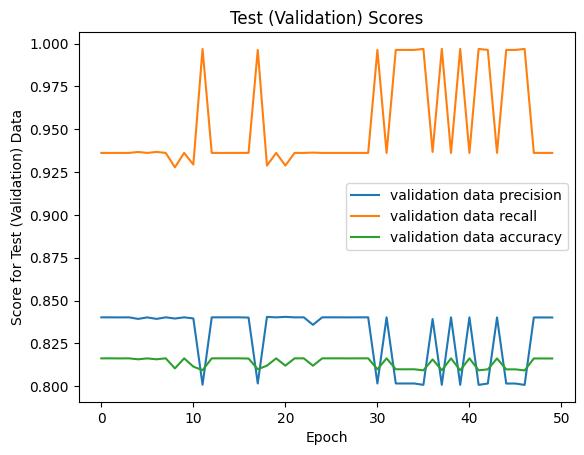

In [41]:
## Plot validation (test) precision and recall
print(len(history.history['val_accuracy']))
epochs1 = list(range(len(history.history['val_accuracy']))) # total number of epochs
plt.plot(epochs1, history.history['val_precision'], label='validation data precision')
plt.plot(epochs1, history.history['val_recall'], label='validation data recall')
plt.plot(epochs1, history.history['val_accuracy'], label='validation data accuracy')
plt.title('Test (Validation) Scores')
plt.xlabel('Epoch')
plt.ylabel('Score for Test (Validation) Data')
plt.legend()

**Summary and Conclusions**
* This can be found within Capstone_Phase2.ipynb, where neural network results are compared against other 2 models.